In [534]:
#Ayman Mohamed Reda Mohamed, Sec: 1, BN: 19
#Ahmed Sayed Abdullah, Sec: 1, BN: 6

In [535]:
from IPython.display import Image
from graphviz import Digraph
import copy
import json
import re




def insert_sequence(str1, str2, index):
    '''
    just a helper function that injects str2 into str1 just after the index given.
    used when resolving the range operator
    '''
    str1_split1 = str1[:index]
    str1_split2 = str1[index:]
    new_string = str1_split1 + str2 + str1_split2
    return new_string





def ClassesPreprocessor(infix):
    '''
    loops on all square brackets, checks for consecutive alphaneumerics, inserts | between them
    so in the case of [a-zA-Z] will be [a-z|A-Z] and in the case of [abc] will be [a|b|c] and the case [a-z] will be [a-z] nothing will change here
    THIS FUNCTION IS TO BE RUN BEFORE 'preprocessor' FUNCTION or you will face some lovely bugs :)
    '''
    alphabet = list("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_{,}!")
    processed_infix = []
    insideClass = False
    for i,c in enumerate(infix):
        processed_infix.append(c)
        if c == '[':
            insideClass = True
            continue
        if c == ']':
            insideClass = False
        if(insideClass and c in alphabet and infix[i+1] in alphabet):
            processed_infix.append('|')
        if(insideClass and c not in alphabet and c != '-'):
            processed_infix = processed_infix[:-1]
            processed_infix.append('|')
            processed_infix.append('/')
            processed_infix.append(c)
    if(insideClass):
      raise ValueError(f"Your Regex is erronous; Square Brackets are not closed")
    return ''.join(processed_infix)

        
def preprocessor(infix):
    '''
    loop on every character c in infix :
	if c is in ['*' , '+', '?',')',']'] and if next character v is anything not in ['*' , '+', '?',')',']' , '.', '|'] :
		append ' . ' right between c and v  (right after c)

    if c is alphabet or digit and next char v is alphabet or digit or opening brackets '(' or '[' :
        append '.' right between c and v (right after c)
    '''
    specials = ['*' , '+', '?',')',']']
    others = ['.', '|']
    alphabet = list("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_{,}!")
    
    out_string = ""
    out_index = 0

    for i, c in enumerate(infix):
        out_string = out_string + c
        out_index = out_index + 1
        if i < len(infix) - 1:
            if c in specials and not(infix[i+1] in specials or infix[i+1] in others):
                out_string = insert_sequence(out_string, '.', out_index)
                out_index = out_index + 1

            elif(c in alphabet and (infix[i+1] in alphabet or infix[i+1] in ['(', '[', '/'])):
                out_string = insert_sequence(out_string, '.', out_index)
                out_index = out_index + 1

    return out_string





def shunt(infix):
    ''' Shunting Yard algorithm, to be run after the preprocessing steps obvs '''
  
    alphabet = list("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_{,}!")
    operators = {'*': 5,                  \
               '+': 4,                  \
                '?': 3,                 \
                '.': 2,                 \
                '|': 1}
  


    # Initializing empty pofix and stack strings
    postfix, stack = "", ""  #a stack is just a string or list :D
    i = 0

    #for every character c in input infix
    while infix != [] and i < len(infix):
        c = infix[i]
        #print(f'\nindex: {i} in infix: {infix} looking at character: {c}')
        
        #if opening bracket
        if c in ['(' , '[']:
            stack = stack + c  #push c to stack

        #if closing bracket
        elif c == ')':
            # pop until we reach the matching bracket
            while stack and stack[-1] != '(':
                postfix = postfix + stack[-1]  #append to postfix
                stack = stack[:-1]  #then pop stack
            if not stack:                    #if stack became empty, meaning the bracket is not opened aslan, then raise error
                raise ValueError(f"Your Regex is erronous; Brackets are opened but not closed")
                return False

            stack = stack[:-1]  # another pop to remove the open bracket in the stack, it is useless
    

        elif c == ']':
            # pop until we reach the matching bracket
            while stack and stack[-1] != '[':
                postfix = postfix + stack[-1]  #append to postfix
                stack = stack[:-1]  #pop stack
            if not stack:                    #if stack became empty, meaning the bracket is not opened aslan
              raise ValueError (f"Your Regex is erronous; Square Brackets are opened but not closed")
              return False

            stack = stack[:-1]  # another pop to remove the open bracket in the stack


        #if c is an operator
        elif c in operators:
            while stack and operators[c] <= operators.get(stack[-1], 0):      #if stack not empty and precedence(c) <= precedence(top of stack)
                postfix, stack = postfix + stack[-1], stack[:-1]                #pop and append to postfix
        
            stack = stack + c                                                 #just push c to stack
        elif c == "/":
            postfix= postfix+c
            i = i+1
            c = infix[i]
            postfix= postfix+c
            print(postfix)



        elif c == '-':
            if(i == len(infix)):                                     #raise error in case of missing second operand bcs input is finished, ex: [A -
                return False
            first = postfix[-1]
            last = infix[i+1]
            if(not(last in alphabet)):                               #raise error in case of second operand is not in alphabet, ex: [A - ()]
                return False

            '''
            construct the new list to be injected into infix, example [a-f] we want to replace '-' by '|b|c|d|e|'
            so we want to get the starting character and the ending character, then construct the list
            then finally inject it into infix using the function insert_sequence
            '''
            processed_list = []
            for v in alphabet:
                if(alphabet.index(v) > alphabet.index(first) and alphabet.index(v) < alphabet.index(last)):
                    processed_list.append('|')
                    processed_list.append(v)
            
            processed_list.append('|')
            infix = insert_sequence(infix, ''.join(processed_list), i+1)
           



        else:   #just a normal character or digit, nothing special, just append to postfix
            postfix = postfix + c

        #print(f'postfix: {postfix}')
        i = i+1

    #finalizing step after infix is empty now, just pop all the stack and append them all to postfix
    while stack:
        if stack[-1] in ['(', '[']:                             #if we found an opened bracket but not closed when finalizing (no more inputs)
            raise ValueError (f"Your Regex is erronous; Brackets or Square Brackets are not closed")
            return False
        postfix, stack = postfix + stack[-1], stack[:-1]


    #final check by using re.compile  ;)
    try:
      re.compile(infix)
    except Exception as e:
      raise ValueError(f"Your Regex is erronous; {e}")
      return False
    #return the result
    return postfix


In [536]:
'''
in my implementation, an edge is just defined by its label and its destination.
why not store the source?
i already handled it, by appending the exact edge to the source state, each source state has list of edges (so we can always trace the source)
also, we are interested in the destination not the source, this will help us more in NFA --> DFA when getting the eps closure
'''
class edge:
      def __init__(self):
        self.label=None
        self.destination=None
      def __str__(self):
        return f"edge {self.label} going to {self.destination}"
  



'''
an NFA state is defined by its label/ID and a list of edges going out of it
I overloaded some helper operators to allow for various computations on different states
'''
class state:
  def __init__(self):
    self.label=None
    self.Out_Edges=[]

  def __repr__(self) -> str:
     return self.label
  def __eq__(self, other):
    return other.label == self.label
  def __ne__(self, other):
    return other.label != self.label
  def __hash__(self):
     return hash(self.label)





'''
an nfa object just contains a start state, an accepting state,
and a bunch of inner states, the inner state INCLUDE the start and accepting states, for the sake of easier development.
'''
class nfa:

    def __init__(self, initial, acc, inner):
        self.start = initial
        self.accept = acc
        self.inner_states = inner
    def __repr__(self) ->str:
      return self.start.label



'''
below are Helper functions that are multiplexed based on the input coming from the stack
if the input is ., then pop 2 nfa objects and concat them then push the resulted nfa back to stack

if the input is |, then pop 2 nfa objects and Or them then push the resulted nfa back to stack

if the input is +, pop 1 nfa only and make a new nfa then push it to stack

if the input is *, same as above

if the input is ?, same as above
'''



def concatNFA (stack):
   
    '''
    this function takes 2 nfa's from the stack, concats them, then pushes the resulted nfa back to stack
    '''   
     
    nfa2 = stack.pop()
    nfa1 = stack.pop()


    nEdge = edge()
    nEdge.label = 'ε'
    nEdge.destination = nfa2.start
    nfa1.accept.Out_Edges.append(nEdge)

    #print(nfa1)
    #print(nfa1.inner_states)

    resultnfa = nfa(nfa1.start,  nfa2.accept, nfa1.inner_states + nfa2.inner_states)
    stack.append(resultnfa)
    return resultnfa

    


def orNFA (stack, id):
  '''
  this function takes 2 NFA's from the stack, ORs them, pushes the resulted NFA back to stack
  '''
  nfa1 = stack.pop()
  nfa2 = stack.pop()
  newStart = state()
  newStart.label= "S"+str(id)
  newEnd = state()
  newEnd.label = "S"+str(id+1)

  nEdge1 = edge()
  nEdge1.label = 'ε'
  nEdge1.destination = nfa1.start

  nEdge2 = edge()
  nEdge2.label = 'ε'
  nEdge2.destination = nfa2.start

  newStart.Out_Edges.append(nEdge1)
  newStart.Out_Edges.append(nEdge2)


  nEdge3 = edge()
  nEdge3.label = 'ε'
  nEdge3.destination = newEnd

  nfa1.accept.Out_Edges.append(nEdge3)

  nEdge4 = edge()
  nEdge4.label = 'ε'
  nEdge4.destination = newEnd
  nfa2.accept.Out_Edges.append(nEdge4)


  result = nfa(newStart, newEnd, [newStart,newEnd]+ nfa1.inner_states + nfa2.inner_states)
  stack.append(result)
  return result, id+2






def ZeroMoreNFA (stack, id):
  '''
  this function pops 1 NFA from the stack, pushes the resulted NFA back to stack
  '''
  nfa1 = stack.pop()



  newStart = state()
  newStart.label = "S"+str(id)
  newEnd = state()
  newEnd.label = "S"+str(id+1)

  nEdge1 = edge()
  nEdge1.label = 'ε'
  nEdge1.destination = newStart
  nfa1.accept.Out_Edges.append(nEdge1)



  nEdge2 = edge()
  nEdge2.label = 'ε'
  nEdge2.destination=nfa1.start
  newStart.Out_Edges.append(nEdge2)

  nEdge3 = edge()
  nEdge3.label = 'ε'
  nEdge3.destination = newEnd
  nfa1.accept.Out_Edges.append(nEdge3)



  nEdge4 = edge()
  nEdge4.label = 'ε'
  nEdge4.destination = newEnd
  newStart.Out_Edges.append(nEdge4)
  
  result = nfa (newStart, newEnd, [newStart, newEnd] + nfa1.inner_states)
  stack.append(result)
  return result, id+2




def OneMoreNFA (stack, id):
   '''
   this function pops 1 NFA from the stack, makes a new NFA then pushes it back to the stack
   '''
   nfa1 = stack.pop()



   newStart = state()
   newStart.label = "S"+str(id)
   newEnd = state()
   newEnd.label = "S"+str(id+1)

   nEdge1 = edge()
   nEdge1.label ='ε'
   nEdge1.destination = newStart
   nfa1.accept.Out_Edges.append(nEdge1)

   nEdge2 = edge()
   nEdge2.label='ε'
   nEdge2.destination=nfa1.start
   newStart.Out_Edges.append(nEdge2)

   nEdge3 = edge()
   nEdge3.label='ε'
   nEdge3.destination = newEnd
   nfa1.accept.Out_Edges.append(nEdge3)


   result = nfa (newStart, newEnd, [newStart, newEnd] + nfa1.inner_states)
   stack.append(result)
   return result, id+2



def ZeroOneNFA (stack, id):
  '''
  this function pops 1 NFA from the stack, makes a new NFA then pushes it back to the stack
  '''
  nfa1 = stack.pop()

  newStart = state()
  newStart.label = "S"+str(id)
  newEnd = state()
  newEnd.label = "S"+str(id+1)

  nEdge1 = edge()
  nEdge1.label='ε'
  nEdge1.destination=nfa1.start
  newStart.Out_Edges.append(nEdge1)

  nEdge2 = edge()
  nEdge2.label='ε'
  nEdge2.destination = newEnd
  nfa1.accept.Out_Edges.append(nEdge2)

  
  nEdge2 = edge()
  nEdge2.label='ε'
  nEdge2.destination = newEnd
  newStart.Out_Edges.append(nEdge2)



  result = nfa (newStart, newEnd, [newStart, newEnd] + nfa1.inner_states)
  stack.append(result)
  return result, id+2




def ConstructNFA (c:str, id:int, stack):
    '''
    this function takes a character, and makes a whole new NFA based on this character, then pushes the new NFA to stack
    '''
    start = state()
    accept = state()
    start.label = "S"+str(id)
    accept.label = "S"+str(id+1)

    nEdge = edge()
    nEdge.label = c
    nEdge.destination = accept
    start.Out_Edges.append(nEdge)
    


    
    result_nfa = nfa(start, accept, [start,accept])
    stack.append(result_nfa)
    #print(result_nfa.inner_states)

    return result_nfa, id+2



In [537]:
class DFA_Edge:
    ''' An edge is just defined by its label and destination SuperState '''
    def __init__(self):
      self.label = None
      self.destination = None           #destination here points to a SuperState not a state


class SuperState:
    '''A superState is defined by a bunch of SubStates, a bunch of outgoing edges, and its label/ID,
      and 2 flags indicating whether or not this SuperState is starting or accepting
    '''
    def __init__(self):
        self.isStart = None          #boolean
        self.isEnd = None            #boolean
        self.Out_Edges = []        #list of edges
        self.SubStates = set()        #list of states
        self.label = None

    def __eq__(self, other):
      set_of_src_labels = set()
      set_of_dst_labels = set()
      for s in self.SubStates:
        set_of_src_labels.add(s.label)
      for s in other.SubStates:
        set_of_dst_labels.add(s.label)
      return set_of_src_labels == set_of_dst_labels

    def __ne__(self, other):
      set_of_src_labels = set()
      set_of_dst_labels = set()
      for s in self.SubStates:
        set_of_src_labels.add(s.label)
      for s in other.SubStates:
        set_of_dst_labels.add(s.label)
      return set_of_src_labels != set_of_dst_labels

    def __str__(self):
      if(self.SubStates):
        stringy = ""
        for sub in self.SubStates:
          stringy = stringy + str(sub) + ","
        return "SuperState " +stringy
      else:
        return "Empty SuperState"

    def __repr__(self):
      if(self.SubStates):
        stringy = ""
        for sub in self.SubStates:
          stringy = stringy + str(sub) + ","
        return stringy
      else:
        return "Empty SuperState"

    def __hash__(self):
      if(self.SubStates):
        stringy = " "
        for sub in self.SubStates:
          stringy = stringy + str(sub) + ","
        return hash("SuperState" +stringy)
      else:
        return hash(None)


class DFA:
    ''' A DFA object contains a set of SuperStates, also a pointer to the starting SuperState and a pointer to the accept SuperState'''
    def __init__(self):
        self.StartSTT = None          #StartSuperState
        self.EndSTT = None            #ending SuperStates
        self.SuperSS = set()           #list of SuperStates
    def __eq__(self, other):
      return self.StartSTT == other.StartSTT and self.SuperSS == self.SuperSS
    def __ne__(self, other):
      return self.StartSTT != other.StartSTT or self.SuperSS != self.SuperSS
    def empt(self):
      self.StartSTT = SuperState()          #StartSuperState
      self.EndSTT = False            #ending SuperStates
      self.SuperSS = set()           #list of SuperStates

def EpsClosure(stat:state):
    '''
    This function gets the direct neighbours from taking the Epsilon edge, just the direct neighbours.
    '''
    epsStates = set()
    epsStates.add(stat)
    for edg in stat.Out_Edges:
        #print(f"state {stat} -> "+str(edg))
        if edg.label == 'ε':
            epsStates.add(edg.destination)
    #print(epsStates)
    return epsStates


def CharClosure(stat:state, C):
    '''
    gets the direct neighbours from taking the Character input edge, just the direct neighbours.
    '''
    closeStates = set()
    #closeStates.add(stat)
    for edg in stat.Out_Edges:
        if edg.label == C:
            closeStates.add(edg.destination)
    
    return closeStates


def getLabelsfromSuperState(SSTT:SuperState):
  ''' Takes a SuperState, returns a list of labels if its SubStates'''
  list_of_labels=[]
  for st in SSTT.SubStates:
    list_of_labels.append(st.label)
  return list_of_labels



def followChar (stat:state, C):
    '''Returns a set of States reachable from taking Char edges recursively'''
    reachable_states = set()
    unchecked_states = set()
    unchecked_states.add(stat)
    checked_states = set()              
    while(unchecked_states):
        to_be_checked = unchecked_states.copy()
        for S in to_be_checked:
            reachable_states.update(CharClosure(S, C))
            unchecked_states.update(CharClosure(S, C))
            unchecked_states.remove(S)
    return reachable_states if reachable_states else False


def followEps(stat:state):
    '''Returns a set of States reachable from taking Epsilon edges recursively'''
    reachable_states = set()
    reachable_states.add(stat)
    unchecked_states = set()
    unchecked_states.add(stat)
    checked_states = set()              #leave it as it is until we are sure that there will be no eps cycles
    countdown = 3
    while(unchecked_states != set() and countdown):
        to_be_checked = unchecked_states.copy()
        prev_checked = checked_states.copy()
        for S in to_be_checked:
            reachable_states.update(EpsClosure(S))
            unchecked_states.update(EpsClosure(S))
            unchecked_states.remove(S)
            checked_states.add(S)
        if(prev_checked == checked_states):
          countdown -= 1
    #print(reachable_states)
    return reachable_states if reachable_states else False



def construct_DFA_Starting_Node(NFA:nfa):
  '''Just makes a new empty DFA, and a legit SuperState then insert this initial SuperState into the Empty DFA then return the DFA'''
  initial_superSet = SuperState()
  initial_superSet.isStart = True
  initial_superSet.label = "S0"
  if(not followEps(NFA.start)):
    #print(f"starting state has no Epsilon transmissions")
    pass
  initial_inner_states = followEps(NFA.start)
  initial_superSet.SubStates.update(initial_inner_states)
  initial_superSet.Out_Edges = []

  startingDFA = DFA()
  startingDFA.StartSTT = initial_superSet
  startingDFA.EndSTT = []
  startingDFA.SuperSS.add(initial_superSet)

  return startingDFA                               #returns the initial DFA



def make_new_superSets(NFA:nfa, SSTT:SuperState, inputChar):
  '''takes a SuperState and an input Character, gets the Char closure from all the substates in the SuperState,
  then makes a new list of reachable states (as a candidate new SuperState), returns this list
  '''
  ListOfSubStates = set()
  if(SSTT.SubStates == set()):
    #print(f"input SuperState does not exist : {SSTT}")
    pass
  for stt in SSTT.SubStates:
    if(not CharClosure(stt, inputChar)):
      #print(f"no more transfers from the given input {inputChar} from the SuperState {SSTT} and sub state {stt}")
      pass
    ListOfSubStates.update(CharClosure(stt, inputChar))
    for st in ListOfSubStates.copy():
      ListOfSubStates.update(followEps(st))
  return ListOfSubStates



def getSuperState_from_list_of_states (dfa:DFA, List_of_states):
  '''takes a list of states, returns the matching SuperState if the list already'''
  for SSTT in dfa.SuperSS:
    if(List_of_states == SSTT.SubStates):
      return SSTT
  return False



def Expand_DFA_based_on_input(dfa:DFA, SSTT:SuperState, nefa:nfa, inputChar, id, SSTT_to_be_checked):
  SuperStatesToBeChecked = set()
  SuperStatesToBeChecked.update(dfa.SuperSS)
  #for SSTT in dfa.SuperSS:
  if (SSTT):
    #SSTT = SuperStatesToBeChecked.pop()
    #print(SSTT)
    #print(f"will now check for {SSTT} for input {inputChar}")
    ListOfSubStates = make_new_superSets(nefa, SSTT, inputChar)                  ##########################
    #print(f"\n\n{ListOfSubStates}\n\n")
    if(not ListOfSubStates):
      return dfa, id
    existingSubStates = []
    for ss in dfa.SuperSS:
      existingSubStates.append(set(ss.SubStates))
    #print(f"List Of SubStates : {ListOfSubStates}")
    #print(f"List Of SubStates : {existingSubStates}")
    if(ListOfSubStates in existingSubStates):
      #if the SuperState already exists, either make a new edge or break and continue to the next SuperState



      if (SSTT.Out_Edges == []):
        #print(f"will construct edge {inputChar} from {SSTT} to {getSuperState_from_list_of_states(dfa, ListOfSubStates)}")
        newEdge2 = DFA_Edge()
        newEdge2.label = inputChar
        if(not getSuperState_from_list_of_states(dfa, ListOfSubStates)):
          #print(f'no super state matches the given list of states : {ListOfSubStates}')
          pass
        newEdge2.destination = getSuperState_from_list_of_states(dfa, ListOfSubStates)
        SSTT.Out_Edges.append(newEdge2)
        return dfa, id


      #if an edge already exists, then continue
      for edg in SSTT.Out_Edges:
        #print(f"{edg.destination} == {getSuperState_from_list_of_states(dfa, ListOfSubStates)} and {edg.label} == {inputChar}")
        if(edg.destination == getSuperState_from_list_of_states(dfa, ListOfSubStates) and edg.label == inputChar): #equality operator overload of superstate
          #continue
          return dfa, id


        #else
        #make an edge to this state and continue
      
      #print(f"will construct edge {inputChar} from {SSTT} to {getSuperState_from_list_of_states(dfa, ListOfSubStates)}")
      newEdge1 = DFA_Edge()
      newEdge1.label = inputChar
      if(not getSuperState_from_list_of_states(dfa, ListOfSubStates)):
        #print(f'no super state matches the given list of states : {ListOfSubStates}')
        pass
      newEdge1.destination = getSuperState_from_list_of_states(dfa, ListOfSubStates)
      SSTT.Out_Edges.append(newEdge1)
      return dfa, id
          
    
      

    else:
      #this superstate does not exist, make a new one
      newSuperState = SuperState()
      newSuperState.isStart = False
      newSuperState.SubStates.update(ListOfSubStates)
      newSuperState.label = "S"+ str(id)
      id = id + 1
      newEdge = DFA_Edge()
      newEdge.label = inputChar
      newEdge.destination = newSuperState
      SSTT.Out_Edges.append(newEdge)
      dfa.SuperSS.add(newSuperState)
      SSTT_to_be_checked.append(newSuperState)
      #SuperStatesToBeChecked.add(newSuperState)
    

  return dfa, id



def getInputCharacters(postfix):
  '''gets any alphaneumeric from our postfix, to make a list of all input characters'''
  alphabet = list("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_{,}!")
  inputChars = set()
  escaped_flag = False
  for c in postfix:
    if c in alphabet or escaped_flag:
      inputChars.add(c)
      escaped_flag = False
    if c == '/':
          escaped_flag = True
  return list(inputChars)



def CompletedDFA (NFA:nfa, postfix):
  inputChars = getInputCharacters(postfix)
  #print(inputChars)
  initDFA = construct_DFA_Starting_Node(NFA)
  tempDFA1 = DFA()
  tempDFA1.empt()
  itera = 0

  id = 1

  countdown = 3

    #if (tempDFA1 != initDFA):
      #print(itera)
  tempDFA1 = copy.copy(initDFA)
  

  SSTT_to_be_checked = []
  SSTT_to_be_checked = list(initDFA.SuperSS)
  i = 0
  while SSTT_to_be_checked != []:
    SSTT = SSTT_to_be_checked.pop()
    for inputc in inputChars:
      initDFA, id = Expand_DFA_based_on_input(initDFA, SSTT, NFA, inputc, id, SSTT_to_be_checked)
    i = i + 1
    
        
    itera = itera + 1

  for SSTT in initDFA.SuperSS:
    if NFA.accept.label in getLabelsfromSuperState(SSTT):
      SSTT.isEnd = True
    else:
      SSTT.isEnd = False
  return initDFA

    

<h1>Vizualization functions</h1>
<ul>
<li><h3>vizualize_NFA</h3><h6>loops on all states, creates nodes for each state, then loops on all edges and creates edge for each edge</h6></li>
<li><h3>vizualize_DFA</h3><h6>same description, but the label for each SuperState is the label of all the substates</h6></li>
<li><h3>vizualize_Cleansed_DFA</h3><h6>same description, but the label for each SuperState is a simple string "S1" or so</h6></li>
<li><h3>vizualize_minDFA</h3><h6>nothing more...</h6></li>
</ul>

In [538]:
def vizualize_NFA(resultNFA):
  gra = Digraph(graph_attr={'rankdir':'LR'})

  #construct nodes first
  for stat in resultNFA.inner_states:
      if(stat.label == resultNFA.start.label):
        gra.node("", _attributes={'shape' : 'none'})
        gra.edge("", stat.label)
      if(stat.label == resultNFA.accept.label):
        gra.node(stat.label, _attributes={'peripheries' : '2'})
      else:
        gra.node(stat.label)

  #for each node, construct edges
  for stat in resultNFA.inner_states:
      for edg in stat.Out_Edges:
          gra.edge(stat.label, edg.destination.label, label=edg.label)
  gra.format = 'png'
  gra.render('NFA', view = True)
  return gra.source




def Vizualize_DFA (dfa:DFA):
  gra = Digraph(graph_attr={'rankdir':'LR'})
  
  id = 0
  for SSTT in dfa.SuperSS:
    if(SSTT.isStart):
      gra.node("", _attributes={'shape' : 'none'})
      gra.edge("", repr(SSTT))
    if(SSTT.isEnd):
      gra.node(repr(SSTT), _attributes={'peripheries' : '2'})
    else:
      gra.node(repr(SSTT))
    id = id + 1
    

  for SSTT in dfa.SuperSS:
    labelsOfSource = ""
    for stt in SSTT.SubStates:
      labelsOfSource = labelsOfSource + stt.label + " , "

    
    for edg in SSTT.Out_Edges:
      gra.edge(repr(SSTT) , repr(edg.destination), label=edg.label)

  gra.format = 'png'
  gra.render('DFA', view=True)
  return gra.source



def Vizualize_cleansed_DFA (dfa:DFA):
  gra = Digraph(graph_attr={'rankdir':'LR', "label":"DFA"})
  id = 0
  for SSTT in dfa.SuperSS:
    if(SSTT.isStart):
      gra.node("", _attributes={'shape' : 'none'})
      gra.edge("", SSTT.label)
    if(SSTT.isEnd):
      gra.node(SSTT.label, _attributes={'peripheries' : '2'})
    else:
      gra.node(SSTT.label)
    id = id + 1
    
  for SSTT in dfa.SuperSS:
    for edg in SSTT.Out_Edges:
      gra.edge(SSTT.label , edg.destination.label, label=edg.label)

  gra.format = 'png'
  gra.render('cleansed_DFA', view= True)
  return gra.source



def Vizualize_min_DFA (SuperSS):
  gra = Digraph(graph_attr={'rankdir':'LR', "label":"minimized DFA"})
  
  for SSTT in SuperSS:
    if(SSTT.isStart):
      gra.node("", _attributes={'shape' : 'none'})
      gra.edge("", SSTT.label)
    if(SSTT.isEnd):
      gra.node(SSTT.label, _attributes={'peripheries' : '2'})
    else:
      gra.node(SSTT.label)
    
  for SSTT in SuperSS:
    for edg in SSTT.Out_Edges:
      gra.edge(SSTT.label , edg.destination, label=edg.label)
  gra.format = 'png'
  gra.render('minDFA', view=True)
  return gra.source


In [539]:


def PostFix_To_NFA(postfix):
  ''' This is just the multiplexer which calls the right functions based on the right inputs '''
  alphabet = list("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_{,}!")
  stack = []
  id = 1

  escaped = False
  for c in postfix:
    if c in alphabet or escaped:
      _, id = ConstructNFA(c, id, stack)
      escaped = False
    elif c == "/":
          escaped = True
    elif c == '*':
      _, id = ZeroMoreNFA(stack, id)
    elif c == '+':
      _, id = OneMoreNFA(stack, id)
    elif c == '?':
      _, id = ZeroOneNFA(stack, id)
    elif c == '.':
      concatNFA(stack)
    elif c == '|':
      _, id = orNFA(stack, id)
    else:
      raise ValueError(f"You entered an unknown Operator {c}")

  result = stack.pop()
  return result, vizualize_NFA(result)



In [540]:
class LowerTriangleMatrix:
  def __init__(self):
    self.pairs = dict()
  def initWithNum(self, n):
    allPairs = []
    for i in range (n-1):
      for j in range(1, n):
        if(i != j):
          newPair = set()
          newPair.add("S"+str(i))
          newPair.add("S"+str(j))
          if(not(newPair in allPairs)):
            self.pairs[tuple(sorted(newPair))]= "empty"
            allPairs.append(newPair)
    #print(allPairs)
  def __str__(self):
    return str(self.pairs)


def InitializationStep (dfa:DFA, lowertri: LowerTriangleMatrix):
  for SSTT in dfa.SuperSS:
    if(SSTT.isEnd):
      for otherSSTT in dfa.SuperSS:
        if SSTT != otherSSTT:
          if otherSSTT.isEnd == False:
            pair = set()
            pair.add(SSTT.label)
            pair.add(otherSSTT.label)
            lowertri.pairs[tuple(sorted(pair))] = "F"
  return lowertri


def GetDestination (SSTT:SuperState, c):
  for edg in SSTT.Out_Edges:
    if edg.label == c:
      return edg.destination
  return False

def GetSSTTfromLabel (dfa:DFA, SSlabel):
  for sstt in dfa.SuperSS:
    if sstt.label == SSlabel:
      return sstt
  return False


def CheckPairStates (dfa:DFA, pair,lowertri: LowerTriangleMatrix, inputChars):
  sourcePair = pair
  if(len(sourcePair) != 2):
    return False
  #print(sourcePair)
  for c in inputChars:
    Destination1 = GetDestination (GetSSTTfromLabel(dfa,sourcePair[0]), c)
    Destination2 = GetDestination (GetSSTTfromLabel(dfa, sourcePair[1]), c)
    #print(Destination1.label)
    destinationPair = []
    if(not isinstance(Destination1, bool) and not isinstance(Destination2,bool)):
      destinationPair.append (Destination1.label)
      destinationPair.append (Destination2.label)
    elif (type(Destination1) != type(Destination2)):
      lowertri.pairs[tuple(sorted(pair))] = "F"
      return 1, lowertri
      #continue
    #print(destinationPair)
    if(not(tuple(sorted(destinationPair)) in lowertri.pairs.keys())):
      continue
    if(lowertri.pairs[tuple(sorted(destinationPair))] == "F" ):
      
      lowertri.pairs[tuple(sorted(pair))] = "F"
      return 1, lowertri
  return 0, lowertri
  
def IterateOverMatrix (dfa:DFA, inputChars):
  lowertri = LowerTriangleMatrix()
  lowertri.initWithNum(len(dfa.SuperSS))
  lowertri = InitializationStep(dfa, lowertri)

  #print(lowertri)
  checkList=[1]
  while(sum(checkList) != 0):
    #print("Iterated on the Matrix")
    checkList= [0]
    for pair in lowertri.pairs.keys():
      if lowertri.pairs[pair] == "empty":
        num, lowertri = CheckPairStates(dfa, pair, lowertri, inputChars)
        checkList.append(num)

  return lowertri



def MinimizeDFA(dfa:DFA, inputChars):
    lowertria = IterateOverMatrix(dfa, inputChars)
    #print(lowertria)
    newDFA = DFA()
    newDFA.empt()
    newStates = dict()
    id = 0
    for pair in lowertria.pairs.keys():
      if lowertria.pairs[pair] == "empty":
        if(newStates == dict()):
          newStates[id] = list(pair)
          id = id +1
        else:
          fl = True
          for k,p in newStates.items():
            if (pair[0] in p or pair[1] in p):
              newStates[k] = list(set(newStates[k] + list(pair)))
              fl = False
          if(fl):
            newStates[id] = list(pair)
            id = id+1
          
    
    for sstt in dfa.SuperSS:
      unique_lonely_state = False
      for p in newStates.values():
        if(sstt.label in p):
          unique_lonely_state = True
      if(not unique_lonely_state):
        newStates[id] = [sstt.label]
        id = id + 1





    SuperSS = []
    for id in newStates.keys():
      #print(f"i will check edges for {newStates[id]}")
      label = "S"+str(id)
      newState = SuperState()
      newState.label = label
      newState.inner_states = newStates[id]
      newState.isStart = False
      newState.isEnd = False
      #print(f"AYMOOOOOOOOOOOn {newState}")
      #print(newStates)
      representativ_state = GetSSTTfromLabel(dfa, newStates[id][0])
      
     
      for edg in representativ_state.Out_Edges:
        
        dest_state = edg.destination
        #print(dest_state.label)
        dest_composite_states = [k for k, v in newStates.items() if dest_state.label in v]
        #print(dest_composite_states)
        for d in dest_composite_states:
          newEdge = edge()
          newEdge.label = edg.label
          newEdge.destination = "S"+str(d)                  
          newState.Out_Edges.append(newEdge)
      SuperSS.append(newState)
      

    #for stt in SuperSS:
    #  newDFA.SuperSS.add(stt)
      #print(stt.label)
      

    for SSTT in dfa.SuperSS:
      if(SSTT.isStart):
        #search for this state in newStates
        for stt in SuperSS:
          #print(f"IAM HEREEE at SS {stt.label} its inner states are {stt.inner_states}")
          if(SSTT.label in stt.inner_states):
            stt.isStart = True
      if(SSTT.isEnd):
        #search for this state in newStates
        for stt in SuperSS:
          if(SSTT.label in stt.inner_states):
            stt.isEnd = True
            #print("ISEND")
    #print(f"finally, those are the final states: \n {newStates}")
    return SuperSS





<h1>To Construct Json Files: </h1>
<h5>
  make a new empty dictionary, set the very first element "startingState" according to the NFA's start state</br>
  then loop on every state inside our NFA,</br>
  make a new dict,</br>
  if the state is accept, set the "isTerminatingState" to True, otherwise False</br>
  loop on every edge going out of this state,</br>
  make a very small dictionary carrying the Edge's label, and a list to all the destinations from this edge.</br>
</br>
  append this small dictionary to the State's dictionary,</br>
  append this State's dictionary to the big NFA dictionary.</br>
</br>
  after all loops are finished, just dump to json file.</br>
<h5>

In [541]:
def Construct_NFAJson (nefa:nfa):
  outputJson = dict()
  outputJson["startingState"] = nefa.start.label
  for stat in nefa.inner_states:
    stateDict = dict()
    if stat == nefa.accept:
      stateDict["isTerminatingState"] = True
    else:
      stateDict["isTerminatingState"] = False
    for edg in stat.Out_Edges:
      if(edg.label in stateDict.keys()):
        stateDict[edg.label] = [] + [stateDict[edg.label]] + [edg.destination.label]
      else:
        stateDict[edg.label] = edg.destination.label
    outputJson[stat.label] = stateDict
  nfaOutFile = open('NFA.json', 'w', encoding="utf-8")
  JsonObject = json.dump(outputJson, nfaOutFile,indent=6, ensure_ascii=False)
  nfaOutFile.close()
  return JsonObject



def Construct_minDFA_Json (dfa):
  outputJson = dict()
  for stat in dfa:
    if(stat.isStart):
      outputJson["startingState"] = stat.label
    stateDict = dict()
    if stat.isEnd:
      stateDict["isTerminatingState"] = True
    else:
      stateDict["isTerminatingState"] = False
    for edg in stat.Out_Edges:
      if(edg.label in stateDict.keys()):
        stateDict[edg.label] = [] + [stateDict[edg.label]] + [edg.destination]
        #stateDict[edg.label].append(edg.destination)
      else:
        stateDict[edg.label] = edg.destination
    outputJson[stat.label] = stateDict
  nfaOutFile = open('minDFA.json', 'w')
  JsonObject = json.dump(outputJson, nfaOutFile,indent=6, ensure_ascii=False)
  nfaOutFile.close()
  return JsonObject


In [542]:
def CompileRegex (inRegex):
  #inRegex = "[a-fA-C]"
  infix = re.sub(" ", "", inRegex)


  classes_handled = ClassesPreprocessor(infix)
  preprocessed = preprocessor(classes_handled)
  print(f"Preprocessed:  {preprocessed}")
  postfix = shunt(preprocessed)

  print(f"\n\nfinal:          {postfix}")

  nefa_out, nfa_GraphSrc = PostFix_To_NFA(postfix)
  src1 = vizualize_NFA(nefa_out)
  #print(src1)

  final = CompletedDFA(nefa_out, postfix)


  src2 = Vizualize_DFA(final)
  #print(src2)

  src3 = Vizualize_cleansed_DFA(final)
  #print(src3)

  inputChars = getInputCharacters(postfix)
  minDFA = MinimizeDFA(final, inputChars)

  src4 = Vizualize_min_DFA(minDFA)
  #print(src4)



  NFAJSON = Construct_NFAJson(nefa_out)
  minDFAJSON = Construct_minDFA_Json(minDFA)


  return src1, src2, src3, src4

In [543]:
#@title input your Regex here
Input_Regex = "a/*bm/+" #@param {type:"string"}
nfa_graph, dfa_graph, cleanDFA_graph, minDFA_graph = CompileRegex(Input_Regex)

Preprocessed:  a./*.b.m./+
a/*
a/*.b.m./+


final:          a/*.b.m./+.


In [544]:
'''
(AB)
(A|B) 
([A-Z])
(A+)
(A*)
(((AB)((A|B)*))(AB))
(A(((B*)|(DA))*))((CG)|(D([DEF])))
(ab
(a([b-c))
((a|b)|)  
(a{3,2})
((((AB)|[X-Z])+)([C-F]*))
(((((ABE)|C)|((([A-C])S)*))+)((AB)C))  
((([a-e_])(([a-c0-3_])*))(([!?])?))
'''

'\n(AB)\n(A|B) \n([A-Z])\n(A+)\n(A*)\n(((AB)((A|B)*))(AB))\n(A(((B*)|(DA))*))((CG)|(D([DEF])))\n(ab\n(a([b-c))\n((a|b)|)  \n(a{3,2})\n((((AB)|[X-Z])+)([C-F]*))\n(((((ABE)|C)|((([A-C])S)*))+)((AB)C))  \n((([a-e_])(([a-c0-3_])*))(([!?])?))\n'

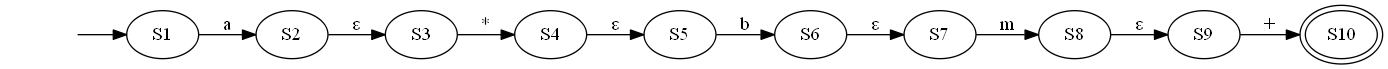

In [545]:
Image("NFA.png")

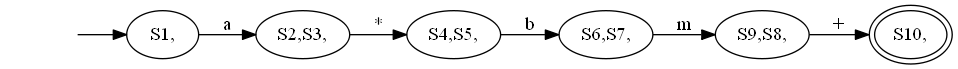

In [546]:
Image("DFA.png")

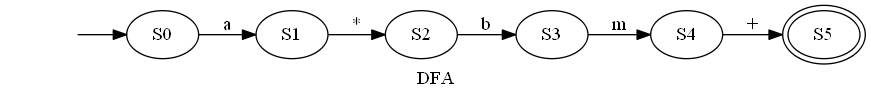

In [547]:
Image("cleansed_DFA.png")

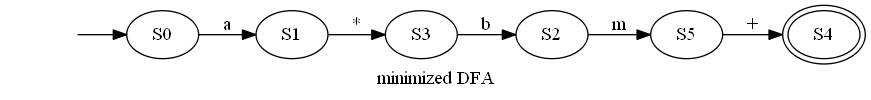

In [548]:
Image("minDFA.png")

In [549]:
'''
import os
import shutil
from google.colab import drive
drive.mount('/content/drive/')


nfa_graph, dfa_graph, cleanDFA_graph, minDFA_graph = CompileRegex(Input_Regex)
path = "/content/drive/MyDrive/CL assignment TestCases/" + Input_Regex


if not(os.path.exists(path)):
  os.mkdir(path)
#os.mkdir(path)


shutil.copyfile('NFA.png', path+'/NFA.png')
shutil.copyfile('DFA.png', path+'/DFA.png')
shutil.copyfile('cleansed_DFA.png', path+'/clean_DFA.png')
shutil.copyfile('minDFA.png', path+'/minDFA.png')
shutil.copyfile('NFA.json', path+'/NFA.json')
shutil.copyfile('minDFA.json', path+'/minDFA.json')

'''


'\nimport os\nimport shutil\nfrom google.colab import drive\ndrive.mount(\'/content/drive/\')\n\n\nnfa_graph, dfa_graph, cleanDFA_graph, minDFA_graph = CompileRegex(Input_Regex)\npath = "/content/drive/MyDrive/CL assignment TestCases/" + Input_Regex\n\n\nif not(os.path.exists(path)):\n  os.mkdir(path)\n#os.mkdir(path)\n\n\nshutil.copyfile(\'NFA.png\', path+\'/NFA.png\')\nshutil.copyfile(\'DFA.png\', path+\'/DFA.png\')\nshutil.copyfile(\'cleansed_DFA.png\', path+\'/clean_DFA.png\')\nshutil.copyfile(\'minDFA.png\', path+\'/minDFA.png\')\nshutil.copyfile(\'NFA.json\', path+\'/NFA.json\')\nshutil.copyfile(\'minDFA.json\', path+\'/minDFA.json\')\n\n'

In [550]:
'''

infix = "[a+bp]"
preprocessed = ""



alphabet = list("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
inside_class = False
for i,c in enumerate(infix):
    if c == "[":
        inside_class = True
    elif c == "]":
        inside_class = False
    if c !='-':
        preprocessed = preprocessed + c
    if(c in alphabet and infix[i+1] in alphabet):
        preprocessed = preprocessed + "|"
    elif c == '-':
        first = infix[i-1]
        last = infix[i+1]
        for inChar in alphabet[alphabet.index(first)+1: alphabet.index(last)]:
            preprocessed = preprocessed + "|"
            preprocessed = preprocessed+'inChar'

print(preprocessed)
            
'''

    

'\n\ninfix = "[a+bp]"\npreprocessed = ""\n\n\n\nalphabet = list("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")\ninside_class = False\nfor i,c in enumerate(infix):\n    if c == "[":\n        inside_class = True\n    elif c == "]":\n        inside_class = False\n    if c !=\'-\':\n        preprocessed = preprocessed + c\n    if(c in alphabet and infix[i+1] in alphabet):\n        preprocessed = preprocessed + "|"\n    elif c == \'-\':\n        first = infix[i-1]\n        last = infix[i+1]\n        for inChar in alphabet[alphabet.index(first)+1: alphabet.index(last)]:\n            preprocessed = preprocessed + "|"\n            preprocessed = preprocessed+\'inChar\'\n\nprint(preprocessed)\n            \n'